
# Rendering XArray data with Vapor

Vapor supports render XArray data in a similar fashion to Numpy data
In order to pass XArray data to Vapor, create a data set of the type `vapor.dataset.PYTHON`
This can also be done with the convenience function `Session.CreatePythonDataset()`.
You can add XArray variables as vapor variables to that dataset by using `Dataset.AddXArrayData`.

These variables can then be rendered normally using any of Vapor's renderers.


In [1]:

import example_utils
from vapor import session, renderer, dataset, camera
import xarray as xr
import numpy as np
from math import cos, sin, pi

ses = session.Session()
data = ses.CreatePythonDataset()

Vapor 3.8.3
Python 3.9.16 (/Users/ncheruku/mambaforge/envs/vapor-cookbook-dev)


OpenGL 4.1 ATI-4.6.21



Below we generate an XArray variable that consists of a curvilinear 2D grid.
You can also open an existing dataset with `xarray.open_dataset` and use variables in that dataset.


In [2]:
def gen2d(w,h,f):
    """Generate a 2D grid of size (w,h) by evaluating f(x,y) for every x,y coordinate"""
    ay = []
    for y in range(0,h):
        ax = []
        for x in range(0,w):
            ax += [f(x,y)]
        ay += [ax]
    return ay

w = h = 8
curveVar = xr.DataArray(
    np.random.randn(8, 8),
    dims=("x", "y"),
    coords={
        "x_coord": xr.DataArray(gen2d(8,8,lambda x,y: cos(y/(h-1)*pi) * (x+(w+1))), dims=("x", "y")),
        "y_coord": xr.DataArray(gen2d(8,8,lambda x,y: sin(y/(h-1)*pi) * (x+(w+1))), dims=("x", "y"))
    })

data.AddXArrayData("variable_name", curveVar)

In [3]:

# Create a renderer for the data

ren = data.NewRenderer(renderer.WireFrameRenderer)
ren.SetVariableName("variable_name")

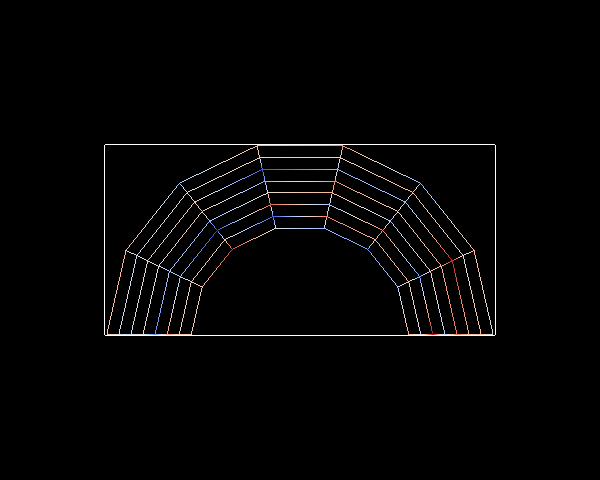

In [4]:

# Show the rendering

ses.GetCamera().ViewAll()
ses.Show()

In [5]:

ses.DeleteRenderer(ren)


Below we generate an XArray variable that consists of a curvilinear 3D grid.


In [6]:

def gen3d(w,h,d,f):
    """Generate a 3D grid of size (w,h,d) by evaluating f(x,y,z) for every x,y,z coordinate"""
    az = []
    for z in range(0,d):
        ay = []
        for y in range(0,h):
            ax = []
            for x in range(0,w):
                ax += [f(x,y,z)]
            ay += [ax]
        az += [ay]
    return az


w = h = d = 8
curveVar = xr.DataArray(
    gen3d(w,h,d,lambda x,y,z: z*w*h + y*w + x),
    dims=("x", "y", "z"),
    coords={
        "x_coord": xr.DataArray(gen2d(w,h,lambda x,y: x), dims=("x", "y")),
        "y_coord": xr.DataArray(gen2d(w,h,lambda x,y: y), dims=("x", "y")),
        "z_coord": xr.DataArray(gen3d(w,h,d,lambda x,y,z: z), dims=("x", "y", "z")),
    })

data.AddXArrayData("variable_3d", curveVar)

In [7]:

# Create a renderer for the data

ren = data.NewRenderer(renderer.WireFrameRenderer)
ren.SetVariableName("variable_3d")

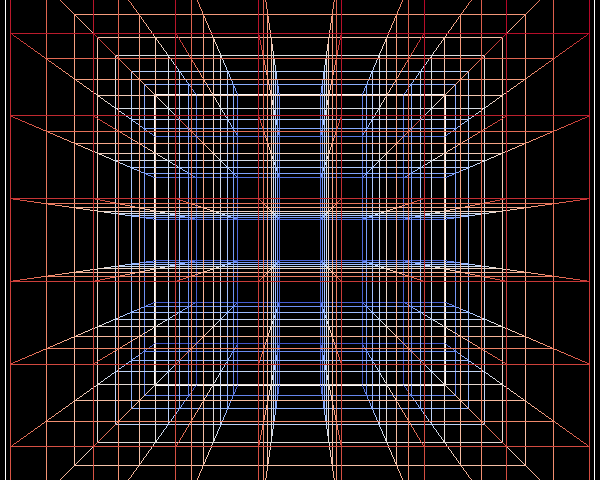

In [8]:

# Show the rendering

ses.GetCamera().ViewAll()
ses.Show()